## 앙상블 코드

- cv값이랑 cond값 지정해주세요 cv 5, cond 2 , 내부 앙상블 5개 => 총 50개 모델 필요

In [5]:
cv=1
cond=1

In [6]:
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from numpy import inf
from numpy import array
from numpy import argmax
import pickle
import argparse, sys, os
import time
from collections import Counter

from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch
from torch.autograd import Variable
from torchsummary import summary
import torchvision.transforms.functional as Fv
from torch.optim import lr_scheduler
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torchvision import datasets, transforms


from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from torchsummary import summary
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

print(torch.__version__)
print(torch.cuda.is_available())
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.parameter import Parameter
from torch import topk
from tqdm.notebook import tqdm # 프로세스 바
from matplotlib import pyplot as plt
import matplotlib
# matplotlib.use('agg')
# device = torch.device("cuda:%d" % 0 if torch.cuda.is_available() else "cpu")
import numpy as np
# from dataloader_hilbert_att import DataLoader
import os
from torch.autograd import Variable


%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

1.12.1
True


In [7]:
path= "\\\\147.47.239.143\\SHRM-robotgear\\ICPHM2023\\pickle\\"

In [8]:
# # read data

with open(path+'cross_val_train_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_set = pickle.load(f)
with open(path+'cross_val_train_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_label = pickle.load(f)
with open(path+'cross_val_test_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_set = pickle.load(f)
with open(path+'cross_val_test_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_label = pickle.load(f)

In [9]:
#depthwise version
class customdataset(Dataset):
    def __init__(self, data, label): 
        super().__init__()
        self.data=torch.tensor(data)
        self.label=torch.tensor(label)
        
    def __len__(self):
        return len(self.label)
  
    def __getitem__(self, idx):
        x = self.data[idx]
        label = self.label[idx] 
                
        return  x.to(device).float(), label.to(device).long()

def loaders(tr_data,tr_label,ts_data,ts_label,random_state):
    train_set, valid_set, train_label, valid_label = train_test_split(tr_data, tr_label,random_state=random_state, train_size=0.75)
    
    traindataset = customdataset(train_set, train_label)
    validdataset = customdataset(valid_set, valid_label)
    testdataset = customdataset(ts_data, ts_label)
    
    traindataloader = DataLoader(traindataset, batch_size=32, shuffle=True, drop_last=True )
    validdataloader = DataLoader(validdataset, batch_size=32, shuffle=True, drop_last=True )
    testdataloader = DataLoader(testdataset, batch_size=1, shuffle=False, drop_last=False )
    
    return traindataloader,validdataloader,testdataloader

### Models

In [10]:
savepath= '\\\\147.47.239.143\\SHRM-robotgear\\ICPHM2023\\형민\\2023 ICPHM\\앙상블모델\\'

#### 기본 Loss

In [11]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

In [12]:
class Dilated_Module(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Dilated_Module,self).__init__()
        self.conv1=nn.Conv1d(in_channels, int(out_channels/4), kernel_size = 5, stride = 1, padding = ((5)//2), dilation=1, bias=False)        
        self.conv2=nn.Conv1d(in_channels, int(out_channels/4), kernel_size = 5, stride = 1, padding = ((5+4*2)//2), dilation=3, bias=False)        
        self.conv3=nn.Conv1d(in_channels, int(out_channels/4), kernel_size = 5, stride = 1, padding = ((5+4*4)//2), dilation=5, bias=False)
        self.conv4=nn.Conv1d(in_channels, int(out_channels/4), kernel_size = 5, stride = 1, padding = ((5+4*6)//2), dilation=7, bias=False)
        
    def forward(self,x):
        ''' input x should be in size [B,F,T], where 
            B = Batch size
            F = features
            T = Time samples
        '''
        x1=self.conv1(x)
        x2=self.conv2(x)
        x3=self.conv3(x)
        x4=self.conv4(x)
        
        y=torch.cat([x1,x2,x3,x4],dim=1)
        
        return y

In [13]:
class MLSTMfcn_MSN(nn.Module):
    def __init__(self, *, num_classes, num_features,
                 num_lstm_out, num_lstm_layers=1, 
                 conv1_nf=128, conv2_nf=256, conv3_nf=128,
                 lstm_drop_p=0.8, fc_drop_p=0.3):
        super(MLSTMfcn_MSN, self).__init__()

        self.num_classes = num_classes
        self.num_features = num_features

        self.num_lstm_out = num_lstm_out
        self.num_lstm_layers = num_lstm_layers

        
        self.conv1_nf = conv1_nf
        self.conv2_nf = conv2_nf
        self.conv3_nf = conv3_nf

        self.dilated_1=Dilated_Module(self.num_features, self.conv1_nf)
        self.dilated_2=Dilated_Module(self.conv1_nf, self.conv2_nf)
        self.dilated_3=Dilated_Module(self.conv2_nf, self.conv3_nf)

        self.lstm_drop_p = lstm_drop_p
        self.fc_drop_p = fc_drop_p

        self.lstm = nn.LSTM(input_size=self.num_features, 
                            hidden_size=self.num_lstm_out,
                            num_layers=self.num_lstm_layers,
                            batch_first=True)
        
        self.bn1 = nn.BatchNorm1d(self.conv1_nf)
        self.bn2 = nn.BatchNorm1d(self.conv2_nf)
        self.bn3 = nn.BatchNorm1d(self.conv3_nf)

        self.se1 = SELayer(self.conv1_nf)  # ex 128
        self.se2 = SELayer(self.conv2_nf)  # ex 256

        self.relu = nn.ReLU()
        self.lstmDrop = nn.Dropout(self.lstm_drop_p)
        self.convDrop = nn.Dropout(self.fc_drop_p)

        self.fc = nn.Linear(self.conv3_nf+self.num_lstm_out, self.num_classes)
    
    def forward(self, x):
        ''' input x should be in size [B,T,F], where 
            B = Batch size
            T = Time samples
            F = features
        '''
        x=x.transpose(2,1)
        ''' input x should be in size [B,T,F], where 
            B = Batch size
            T = Time samples
            F = features
        '''       
        # x1 = nn.utils.rnn.pack_padded_sequence(x, seq_lens, 
        #                                        batch_first=True, 
        #                                        enforce_sorted=False)
        x1, (ht,ct) = self.lstm(x)
        x1 = self.lstmDrop(x1)
        # x1, _ = nn.utils.rnn.pad_packed_sequence(x1, batch_first=True, 
        #                                          padding_value=0.0)
        # print(x1.size())
        x1 = x1[:,-1,:]
        
        x2 = x.transpose(2,1)
        x2 = self.convDrop(self.relu(self.bn1(self.dilated_1(x2))))
        # print(x2.size())
        x2 = self.se1(x2)
        x2 = self.convDrop(self.relu(self.bn2(self.dilated_2(x2))))
        # print(x2.size())
        x2 = self.se2(x2)
        x2 = self.convDrop(self.relu(self.bn3(self.dilated_3(x2))))
        # print(x2.size())
        x2 = torch.mean(x2,2)
        
        x_all = torch.cat((x1,x2),dim=1)
        x_out = self.fc(x_all)
        x_out = F.log_softmax(x_out, dim=1)

        return x_out,x_all

### 공통실행

In [14]:
def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for inputs, labels in testloader:
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)

        output,_ = model.forward(inputs)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss,accuracy

In [15]:
def fail_index(pred, real, cross_val_num):
    failed=[]
    with open('test_fold_index_2.pickle', 'rb') as f:
        test_fold_index = pickle.load(f)
    
    for i in range(len(pred)):
        if pred[i].item()!=real[i].detach().cpu().item():
            failed.append(test_fold_index[cross_val_num-1][i])
    
    return failed

import seaborn as sn
def confusionmatrix(y_pred1, y_test1, column=['class0','class1','class2','class3','class4']):
    # y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    # _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    a=[]
    b=[]
    for i in range(len(y_test1)):
        a.append(y_test1[i].detach().cpu().item())
        b.append(y_pred1[i].item())
    y_test=a
    y_pred=b
    df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred))
    df_cm.index=column
    df_cm.columns=column
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    b, t = plt.ylim() 
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t)
    

    df_cm =df_cm / df_cm.astype(np.float).sum(axis=1)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    b, t = plt.ylim() 
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t)

    
def test(classifier, dataloader):
    # setup the network
    predlist=[]
    real=[]    

    classifier.eval()
    correct = 0.0
    
    max_tr_score = 0
    max_val_score = 0
    for batch_idx, (data) in enumerate(dataloader):
    
        signal1,label = data
        signal1,label = Variable(signal1.cuda()),Variable(label.cuda().long())
        out,_ = classifier(signal1)   

        pred = out.data.max(1, keepdim= True)[1]
        predlist.append(pred.cpu().detach().numpy().squeeze())
        real.append(label)        
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()

        # predlist.append(pred)
    print('\nAccuracy: {}/{} ({:.4f}%)\n'.format(
        correct, len(dataloader.dataset), 100. * float(correct) / len(dataloader.dataset)))
    acc=100. * float(correct) / len(dataloader.dataset)
    return acc,predlist,real

In [16]:
from sklearn.model_selection import ParameterGrid
# 하이퍼파라미터 그리드 설정
param_grid = {
    'lr': [0.001, 0.0005, 0.0001],
    'batch_size': [32, 64, 128],
    'hidden_size': [8, 64, 128],
    'optimizer': ['Adam', 'RMSprop', 'SGD']
}

In [17]:
lr = param_grid['lr'][0]
batch_size = param_grid['batch_size'][0]
num_lstm_out = param_grid['hidden_size'][0]
optimizer_name = param_grid['optimizer'][0]

In [18]:
randomseedlist=[4444,2514,4040,8282,1004]

In [19]:
def final(modelname,train_set, train_label, test_set, test_label,esbnum):
    train_loader,valid_loader,test_loader=loaders(train_set, train_label,test_set,test_label,randomseedlist[esbnum])


    valid_loss_min = np.Inf # track change in validation loss
    criterion = nn.NLLLoss().to(device)
    epochs=500
    print_every=1000

    # 0.001 32 8 Adam
    lr = param_grid['lr'][0]
    batch_size = param_grid['batch_size'][0]
    num_lstm_out = param_grid['hidden_size'][0]
    optimizer_name = param_grid['optimizer'][0]

    model =modelname.to(device)


    # 옵티마이저 설정
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)



    #train
    steps = 0

    for e in tqdm(range(epochs)):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for inputs, labels in train_loader:
            steps += 1

            inputs = inputs.float()
            inputs, labels = inputs.to(device),labels.to(device)

            optimizer.zero_grad()
            # print(inputs.shape)
            # print(model.forward(inputs).shape)
            output,_ = model.forward(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, valid_loader, criterion)

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.6f}.. ".format(train_loss/print_every),
                      "Val Loss: {:.6f}.. ".format(valid_loss/len(valid_loader)),
                      "Val Accuracy: {:.2f}%".format(accuracy/len(valid_loader)*100))

                # save model if validation loss has decreased
                if valid_loss <= valid_loss_min:
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    valid_loss))
                    torch.save(model.state_dict(), savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(esbnum)+'.pt')
                    valid_loss_min = valid_loss

                train_loss = 0

                model.train()
    return model

### ensemble1

In [20]:
ensemble1 = MLSTMfcn_MSN(num_classes=5, 
                           num_features=3,
                           num_lstm_out=num_lstm_out).to(device)
ensemble2 = MLSTMfcn_MSN(num_classes=5, 
                           num_features=3,
                           num_lstm_out=num_lstm_out).to(device)
ensemble3 = MLSTMfcn_MSN(num_classes=5, 
                           num_features=3,
                           num_lstm_out=num_lstm_out).to(device)
ensemble4 = MLSTMfcn_MSN(num_classes=5, 
                           num_features=3,
                           num_lstm_out=num_lstm_out).to(device)
ensemble5 = MLSTMfcn_MSN(num_classes=5, 
                           num_features=3,
                           num_lstm_out=num_lstm_out).to(device)

### 테스트 

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
train_loader,valid_loader,test_loader=loaders(cross_val_train_set,cross_val_train_label,cross_val_test_set,cross_val_test_label,1004)

In [81]:
def test(classifier1,classifier2,classifier3,classifier4,classifier5, dataloader):
    # setup the network
    predlist=[]
    predlist2=[]
    real=[]    

    classifier1.eval()
    classifier2.eval()
    classifier3.eval()
    classifier4.eval()
    classifier5.eval()
    correct = 0.0
    
    max_tr_score = 0
    max_val_score = 0
    for batch_idx, (data) in enumerate(dataloader):
    
        signal1,label = data
        signal1,label = Variable(signal1.cuda()),Variable(label.cuda().long())
        
        
        out1,_ = classifier1(signal1)
        out2,_ = classifier2(signal1) 
        out3,_ = classifier3(signal1)
        out4,_ = classifier4(signal1)
        out5,_ = classifier5(signal1)

        
        out=(out1+out2+out3+out4+out5)/5
        
        pred = out.data.max(1, keepdim= True)[1]
        
        pred1 = out1.data.max(1, keepdim= True)[1].cpu().detach().numpy().squeeze()
        pred2 = out2.data.max(1, keepdim= True)[1].cpu().detach().numpy().squeeze()
        pred3 = out3.data.max(1, keepdim= True)[1].cpu().detach().numpy().squeeze()
        pred4 = out4.data.max(1, keepdim= True)[1].cpu().detach().numpy().squeeze()
        pred5 = out5.data.max(1, keepdim= True)[1].cpu().detach().numpy().squeeze()
        predlist.append(pred.cpu().detach().numpy().squeeze())
        predlist2.append([pred1,pred2,pred3,pred4,pred5])
        real.append(label)        
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()

        # predlist.append(pred)
    print('\nAccuracy: {}/{} ({:.4f}%)\n'.format(
        correct, len(dataloader.dataset), 100. * float(correct) / len(dataloader.dataset)))
    acc=100. * float(correct) / len(dataloader.dataset)
    return acc,predlist,real,predlist2

In [83]:
cv=1
cond=1
# # read data

with open(path+'cross_val_train_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_set = pickle.load(f)
with open(path+'cross_val_train_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_label = pickle.load(f)
with open(path+'cross_val_test_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_set = pickle.load(f)
with open(path+'cross_val_test_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_label = pickle.load(f)
    
train_loader,valid_loader,test_loader=loaders(cross_val_train_set,cross_val_train_label,cross_val_test_set,cross_val_test_label,1004)

ensemble1.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(1)+'.pt'))
ensemble2.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(2)+'.pt'))
ensemble3.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(3)+'.pt'))
ensemble4.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(4)+'.pt'))
ensemble5.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(0)+'.pt'))
acc1_1,predlist1_1,real1_1,hardvote11= test(ensemble1,ensemble2,ensemble3,ensemble4,ensemble5, test_loader)
fail_list1_1,fail_label1_1=fail_data(predlist2_1,real2_1,test_loader)



Accuracy: 9961.0/10000 (99.6100%)



In [84]:
cv=2
cond=1
# # read data

with open(path+'cross_val_train_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_set = pickle.load(f)
with open(path+'cross_val_train_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_label = pickle.load(f)
with open(path+'cross_val_test_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_set = pickle.load(f)
with open(path+'cross_val_test_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_label = pickle.load(f)
    
train_loader,valid_loader,test_loader=loaders(cross_val_train_set,cross_val_train_label,cross_val_test_set,cross_val_test_label,1004)

ensemble1.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(1)+'.pt'))
ensemble2.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(2)+'.pt'))
ensemble3.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(3)+'.pt'))
ensemble4.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(4)+'.pt'))
ensemble5.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(0)+'.pt'))
acc2_1,predlist2_1,real2_1,hardvote21= test(ensemble1,ensemble2,ensemble3,ensemble4,ensemble5, test_loader)
fail_list2_1,fail_label2_1=fail_data(predlist2_1,real2_1,test_loader)



Accuracy: 9949.0/10000 (99.4900%)



In [85]:
cv=3
cond=1
# # read data

with open(path+'cross_val_train_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_set = pickle.load(f)
with open(path+'cross_val_train_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_label = pickle.load(f)
with open(path+'cross_val_test_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_set = pickle.load(f)
with open(path+'cross_val_test_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_label = pickle.load(f)
    
train_loader,valid_loader,test_loader=loaders(cross_val_train_set,cross_val_train_label,cross_val_test_set,cross_val_test_label,1004)

ensemble1.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(1)+'.pt'))
ensemble2.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(2)+'.pt'))
ensemble3.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(3)+'.pt'))
ensemble4.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(4)+'.pt'))
ensemble5.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(0)+'.pt'))
acc3_1,predlist3_1,real3_1,hardvote31= test(ensemble1,ensemble2,ensemble3,ensemble4,ensemble5, test_loader)
fail_list3_1,fail_label3_1=fail_data(predlist3_1,real3_1,test_loader)



Accuracy: 9959.0/10000 (99.5900%)



In [86]:
cv=4
cond=1
# # read data

with open(path+'cross_val_train_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_set = pickle.load(f)
with open(path+'cross_val_train_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_label = pickle.load(f)
with open(path+'cross_val_test_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_set = pickle.load(f)
with open(path+'cross_val_test_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_label = pickle.load(f)
    
train_loader,valid_loader,test_loader=loaders(cross_val_train_set,cross_val_train_label,cross_val_test_set,cross_val_test_label,1004)

ensemble1.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(1)+'.pt'))
ensemble2.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(2)+'.pt'))
ensemble3.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(3)+'.pt'))
ensemble4.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(4)+'.pt'))
ensemble5.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(0)+'.pt'))
acc4_1,predlist4_1,real4_1,hardvote41= test(ensemble1,ensemble2,ensemble3,ensemble4,ensemble5, test_loader)
fail_list4_1,fail_label4_1=fail_data(predlist4_1,real4_1,test_loader)



Accuracy: 9956.0/10000 (99.5600%)



In [87]:
cv=5
cond=1
# # read data

with open(path+'cross_val_train_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_set = pickle.load(f)
with open(path+'cross_val_train_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_label = pickle.load(f)
with open(path+'cross_val_test_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_set = pickle.load(f)
with open(path+'cross_val_test_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_label = pickle.load(f)
    
train_loader,valid_loader,test_loader=loaders(cross_val_train_set,cross_val_train_label,cross_val_test_set,cross_val_test_label,1004)

ensemble1.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(1)+'.pt'))
ensemble2.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(2)+'.pt'))
ensemble3.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(3)+'.pt'))
ensemble4.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(4)+'.pt'))
ensemble5.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(0)+'.pt'))
acc5_1,predlist5_1,real5_1,hardvote51= test(ensemble1,ensemble2,ensemble3,ensemble4,ensemble5, test_loader)
fail_list5_1,fail_label5_1=fail_data(predlist5_1,real5_1,test_loader)



Accuracy: 9963.0/10000 (99.6300%)



In [88]:
cv=1
cond=2
# # read data

with open(path+'cross_val_train_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_set = pickle.load(f)
with open(path+'cross_val_train_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_label = pickle.load(f)
with open(path+'cross_val_test_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_set = pickle.load(f)
with open(path+'cross_val_test_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_label = pickle.load(f)
    
train_loader,valid_loader,test_loader=loaders(cross_val_train_set,cross_val_train_label,cross_val_test_set,cross_val_test_label,1004)

ensemble1.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(1)+'.pt'))
ensemble2.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(2)+'.pt'))
ensemble3.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(3)+'.pt'))
ensemble4.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(4)+'.pt'))
ensemble5.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(0)+'.pt'))
acc1_2,predlist1_2,real1_2,hardvote12= test(ensemble1,ensemble2,ensemble3,ensemble4,ensemble5, test_loader)
fail_list1_2,fail_label1_2=fail_data(predlist1_2,real1_2,test_loader)



Accuracy: 9967.0/10000 (99.6700%)



In [89]:
cv=2
cond=2
# # read data

with open(path+'cross_val_train_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_set = pickle.load(f)
with open(path+'cross_val_train_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_label = pickle.load(f)
with open(path+'cross_val_test_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_set = pickle.load(f)
with open(path+'cross_val_test_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_label = pickle.load(f)
    
train_loader,valid_loader,test_loader=loaders(cross_val_train_set,cross_val_train_label,cross_val_test_set,cross_val_test_label,1004)

ensemble1.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(1)+'.pt'))
ensemble2.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(2)+'.pt'))
ensemble3.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(3)+'.pt'))
ensemble4.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(4)+'.pt'))
ensemble5.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(0)+'.pt'))
acc2_2,predlist2_2,real2_2,hardvote22= test(ensemble1,ensemble2,ensemble3,ensemble4,ensemble5, test_loader)
fail_list2_2,fail_label2_2=fail_data(predlist2_2,real2_2,test_loader)



Accuracy: 9967.0/10000 (99.6700%)



In [90]:
cv=3
cond=2
# # read data

with open(path+'cross_val_train_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_set = pickle.load(f)
with open(path+'cross_val_train_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_label = pickle.load(f)
with open(path+'cross_val_test_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_set = pickle.load(f)
with open(path+'cross_val_test_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_label = pickle.load(f)
    
train_loader,valid_loader,test_loader=loaders(cross_val_train_set,cross_val_train_label,cross_val_test_set,cross_val_test_label,1004)

ensemble1.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(1)+'.pt'))
ensemble2.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(2)+'.pt'))
ensemble3.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(3)+'.pt'))
ensemble4.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(4)+'.pt'))
ensemble5.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(0)+'.pt'))
acc3_2,predlist3_2,real3_2,hardvote32= test(ensemble1,ensemble2,ensemble3,ensemble4,ensemble5, test_loader)
fail_list3_2,fail_label3_2=fail_data(predlist3_2,real3_2,test_loader)



Accuracy: 9962.0/10000 (99.6200%)



In [91]:
cv=4
cond=2
# # read data

with open(path+'cross_val_train_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_set = pickle.load(f)
with open(path+'cross_val_train_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_label = pickle.load(f)
with open(path+'cross_val_test_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_set = pickle.load(f)
with open(path+'cross_val_test_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_label = pickle.load(f)
    
train_loader,valid_loader,test_loader=loaders(cross_val_train_set,cross_val_train_label,cross_val_test_set,cross_val_test_label,1004)

ensemble1.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(1)+'.pt'))
ensemble2.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(2)+'.pt'))
ensemble3.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(3)+'.pt'))
ensemble4.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(4)+'.pt'))
ensemble5.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(0)+'.pt'))
acc4_2,predlist4_2,real4_2,hardvote42= test(ensemble1,ensemble2,ensemble3,ensemble4,ensemble5, test_loader)
fail_list4_2,fail_label4_2=fail_data(predlist4_2,real4_2,test_loader)



Accuracy: 9961.0/10000 (99.6100%)



In [92]:
cv=5
cond=2
# # read data

with open(path+'cross_val_train_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_set = pickle.load(f)
with open(path+'cross_val_train_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_train_label = pickle.load(f)
with open(path+'cross_val_test_set_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_set = pickle.load(f)
with open(path+'cross_val_test_label_'+str(cv)+'_'+str(cond)+'.pickle', 'rb') as f:
    cross_val_test_label = pickle.load(f)
    
train_loader,valid_loader,test_loader=loaders(cross_val_train_set,cross_val_train_label,cross_val_test_set,cross_val_test_label,1004)

ensemble1.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(1)+'.pt'))
ensemble2.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(2)+'.pt'))
ensemble3.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(3)+'.pt'))
ensemble4.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(4)+'.pt'))
ensemble5.load_state_dict(torch.load(savepath+ 'malstm_msn_cv_'+str(cv)+'_cond_'+str(cond)+'_esb_'+str(0)+'.pt'))
acc5_2,predlist5_2,real5_2,hardvote52= test(ensemble1,ensemble2,ensemble3,ensemble4,ensemble5, test_loader)
fail_list5_2,fail_label5_2=fail_data(predlist5_2,real5_2,test_loader)



Accuracy: 9967.0/10000 (99.6700%)



In [77]:
fail_list_condition1=[]
fail_label_condition1=[]
fail_list_condition2=[]
fail_label_condition2=[]

fail_list_condition1.append(fail_list1_1)
fail_list_condition1.append(fail_list2_1)
fail_list_condition1.append(fail_list3_1)
fail_list_condition1.append(fail_list4_1)
fail_list_condition1.append(fail_list5_1)

fail_label_condition1.append(fail_label1_1)
fail_label_condition1.append(fail_label2_1)
fail_label_condition1.append(fail_label3_1)
fail_label_condition1.append(fail_label4_1)
fail_label_condition1.append(fail_label5_1)

fail_list_condition2.append(fail_list1_2)
fail_list_condition2.append(fail_list2_2)
fail_list_condition2.append(fail_list3_2)
fail_list_condition2.append(fail_list4_2)
fail_list_condition2.append(fail_list5_2)

fail_label_condition2.append(fail_label1_2)
fail_label_condition2.append(fail_label2_2)
fail_label_condition2.append(fail_label3_2)
fail_label_condition2.append(fail_label4_2)
fail_label_condition2.append(fail_label5_2)


In [78]:
with open('fail_list_condition1.pickle', 'wb') as f:
    pickle.dump(fail_list_condition1, f)
with open('fail_label_condition1.pickle', 'wb') as f:
    pickle.dump(fail_label_condition1, f)
    
with open('fail_list_condition2.pickle', 'wb') as f:
    pickle.dump(fail_list_condition2, f)
with open('fail_label_condition2.pickle', 'wb') as f:
    pickle.dump(fail_label_condition2, f)

In [79]:
len(fail_list_condition1)

5

In [34]:
predlist[0]==real[0]

False

In [48]:
def fail_data(pred, real, dataloader):
    datalist=[]
    labellist=[]
    
    for batch_idx, (data) in enumerate(dataloader):
    
        signal1,label = data
        datalist.append(signal1)
        labellist.append(label)
    failist=[]
    faillabel=[]
    for i in range(len(pred)):
        if pred[i].item()!=real[i].detach().cpu().item():
            failist.append(datalist[i].detach().cpu())
            faillabel.append(labellist[i].detach().cpu().item())
        
    return failist,faillabel

In [46]:
fail_list,fail_label=fail_data(predlist,real,test_loader)

In [54]:
fail_list[0][0].shape

torch.Size([3, 200])

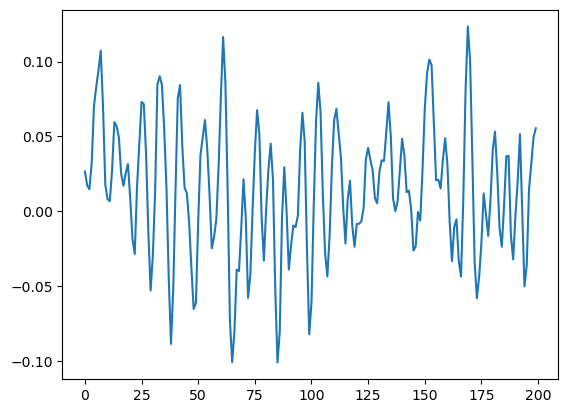

In [58]:
plt.plot(fail_list[0][0][1])


In [49]:
def plotting(fail,title):
    plt.figure(figsize=(10,4))
    plt.suptitle(title)
    plt.subplot(3,1,1)
    plt.plot(fail[0])
    plt.subplot(3,1,2)
    plt.plot(fail[1])
    plt.subplot(3,1,3)
    plt.plot(fail[2])
    plt.show()

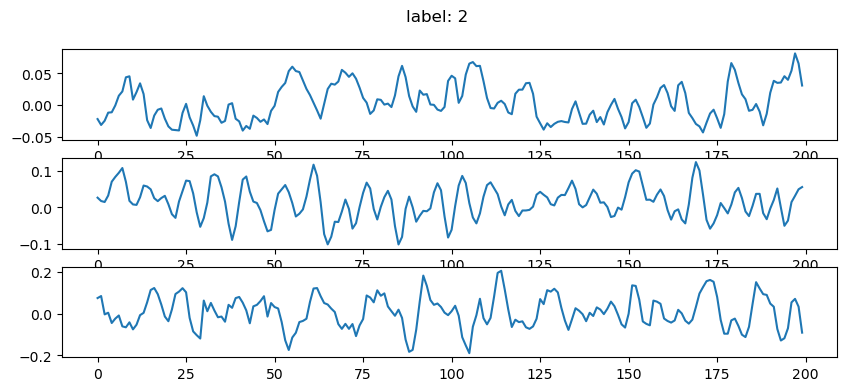

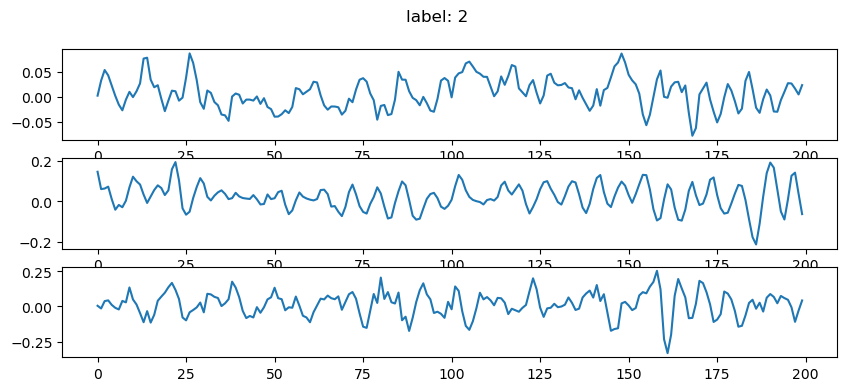

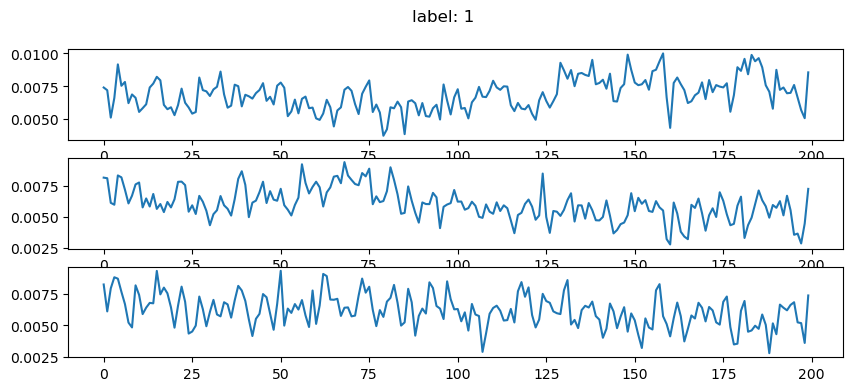

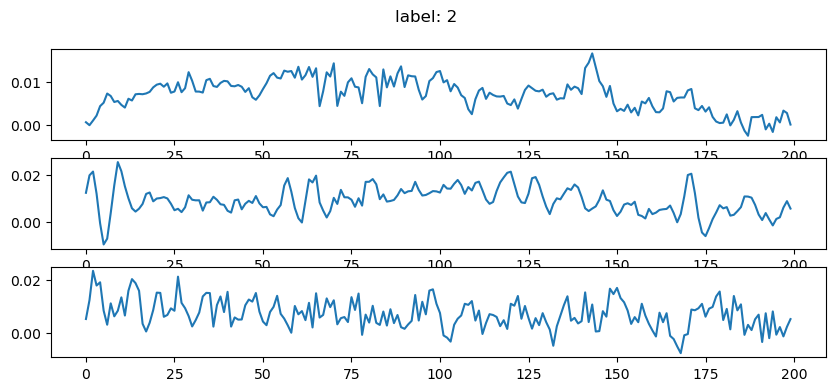

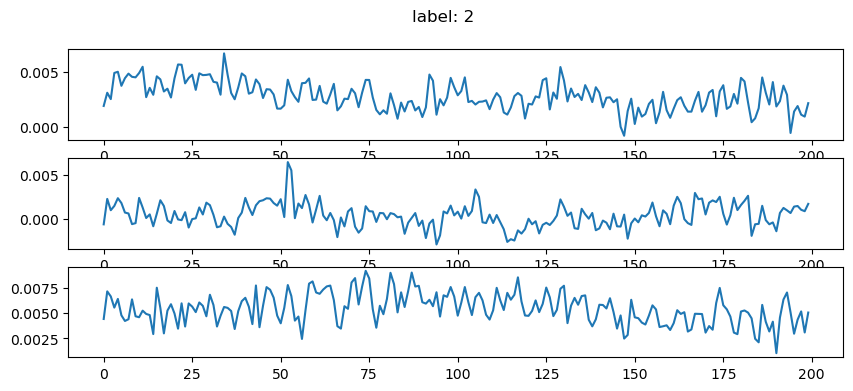

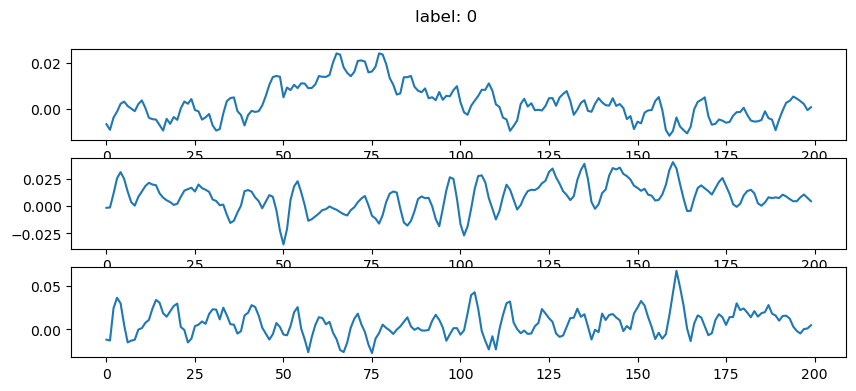

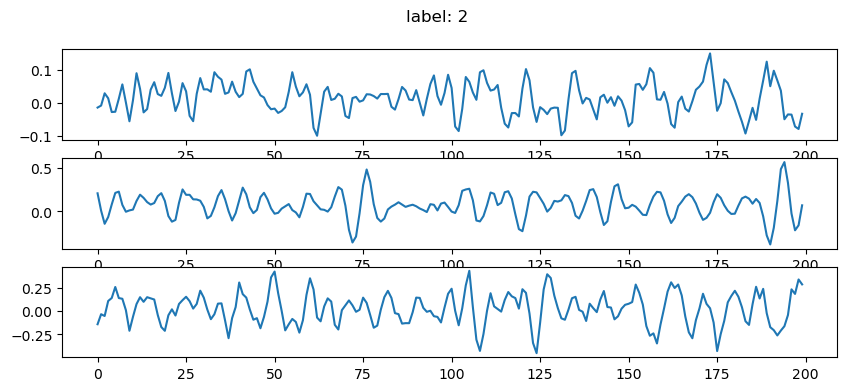

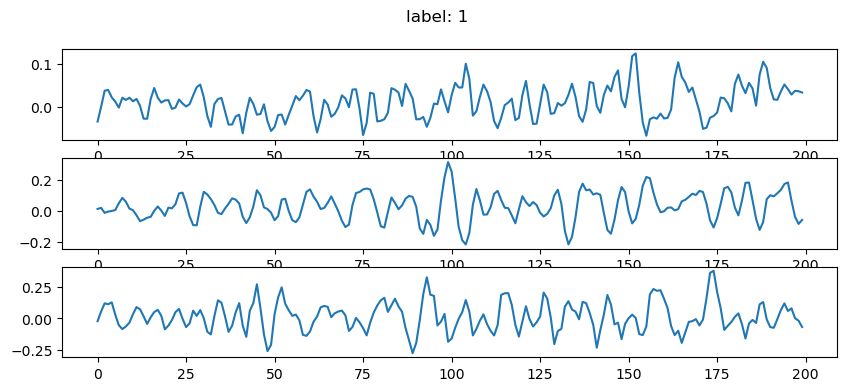

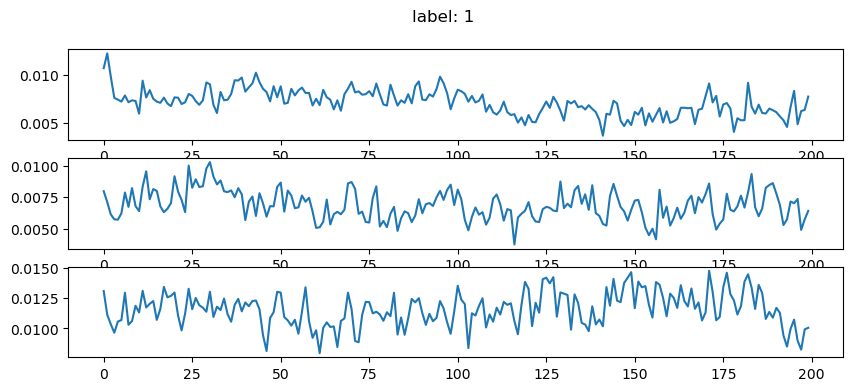

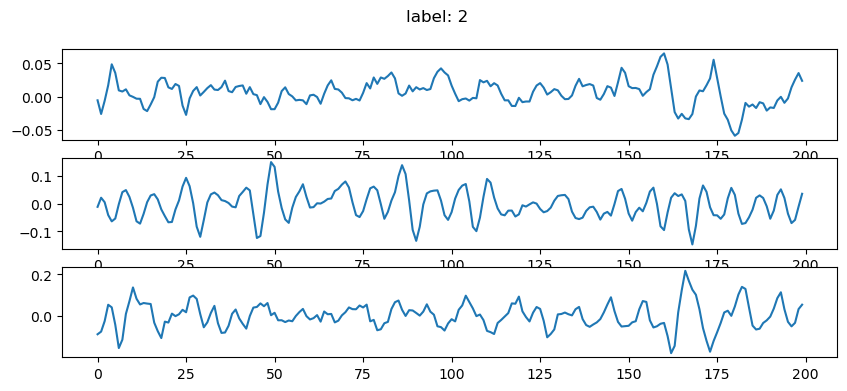

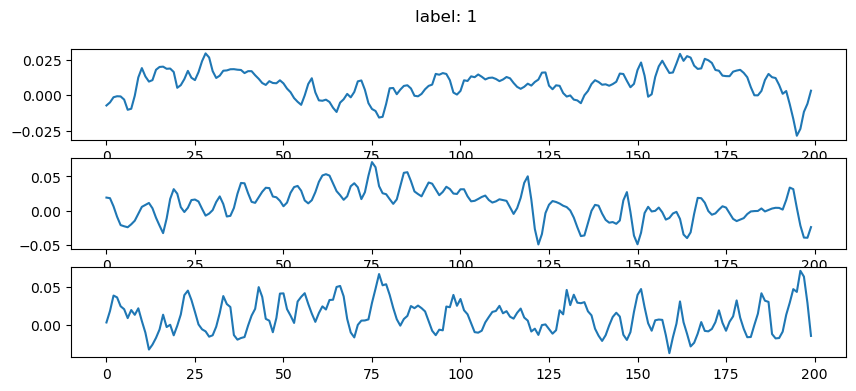

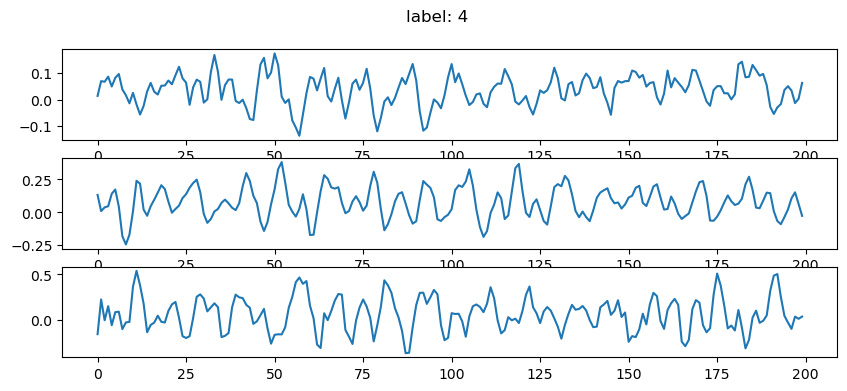

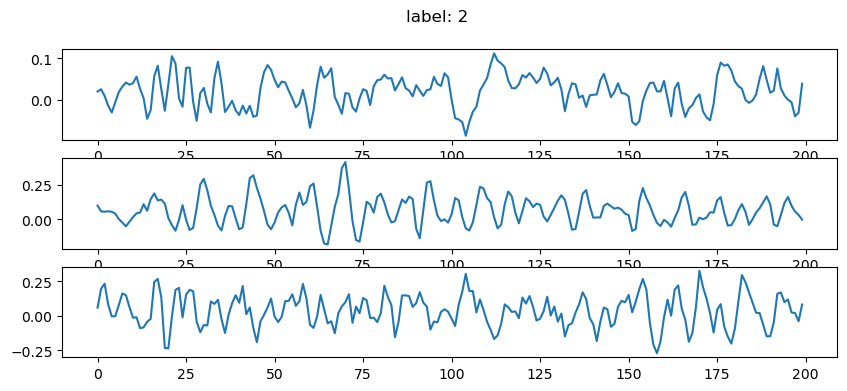

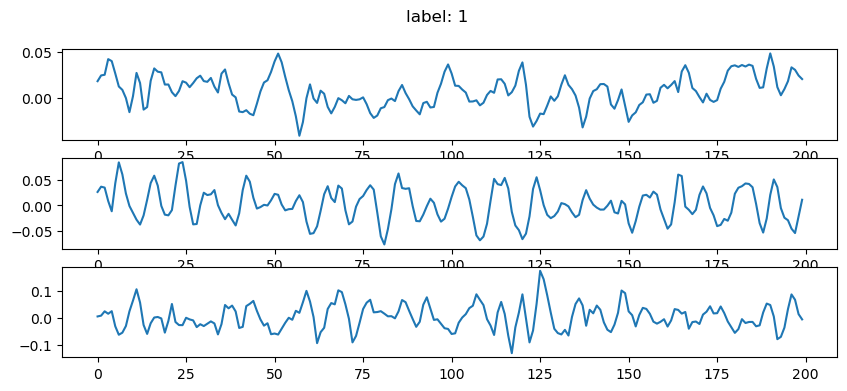

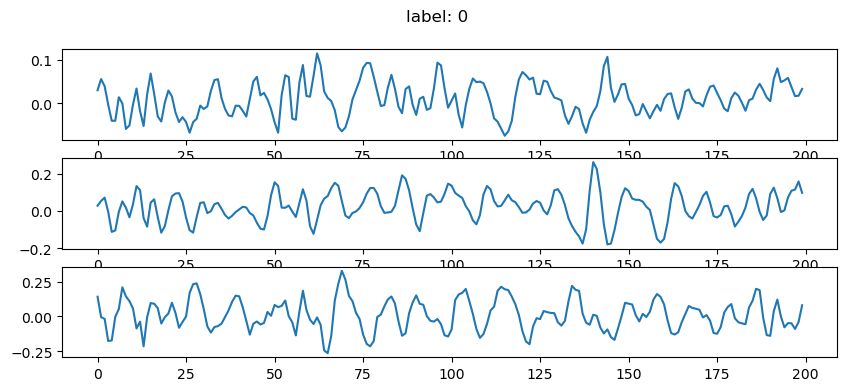

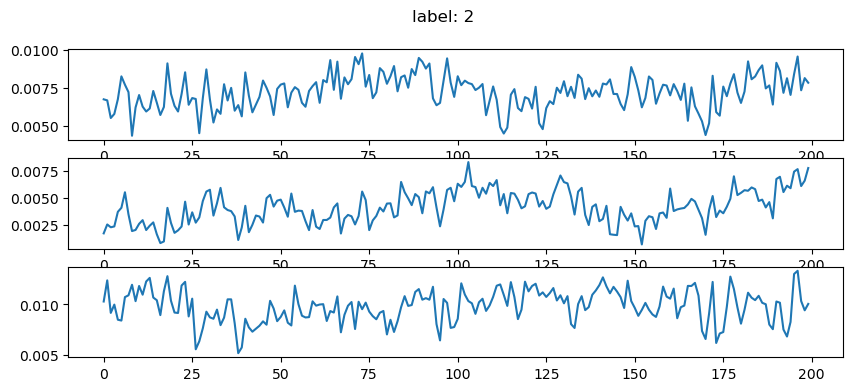

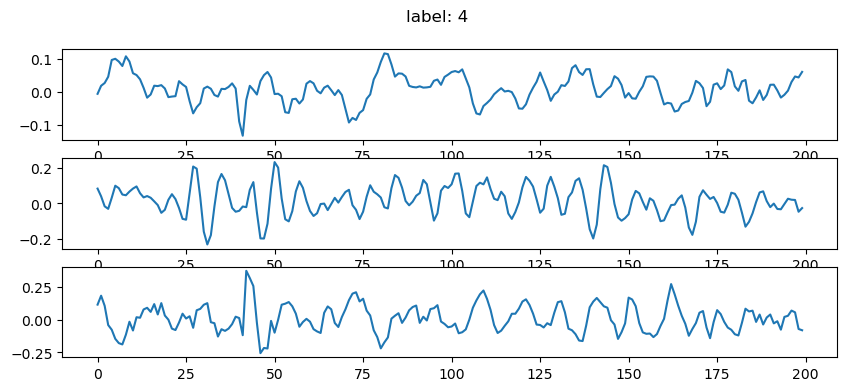

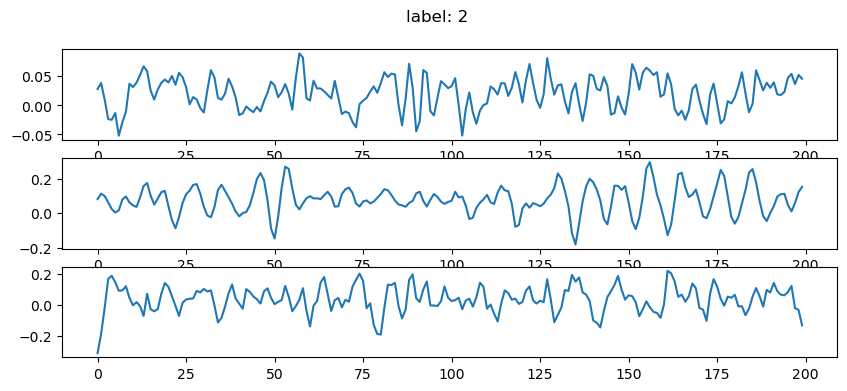

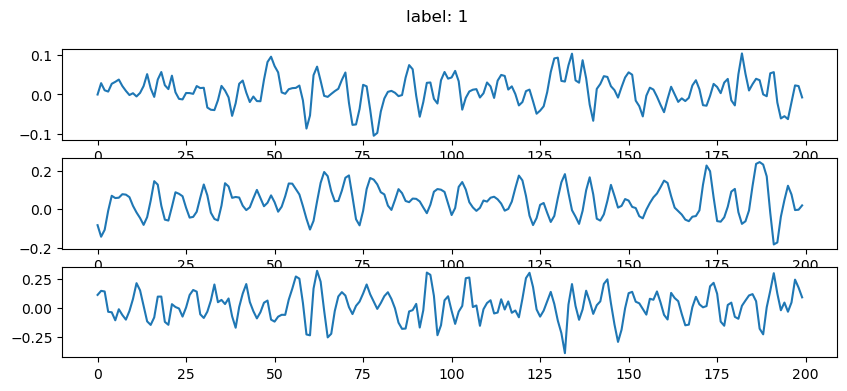

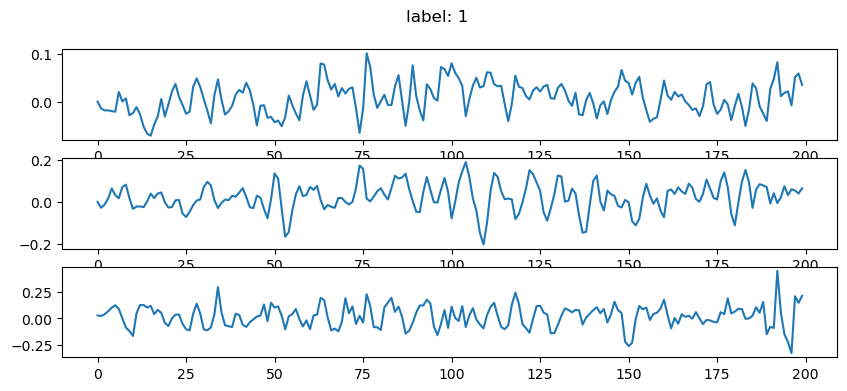

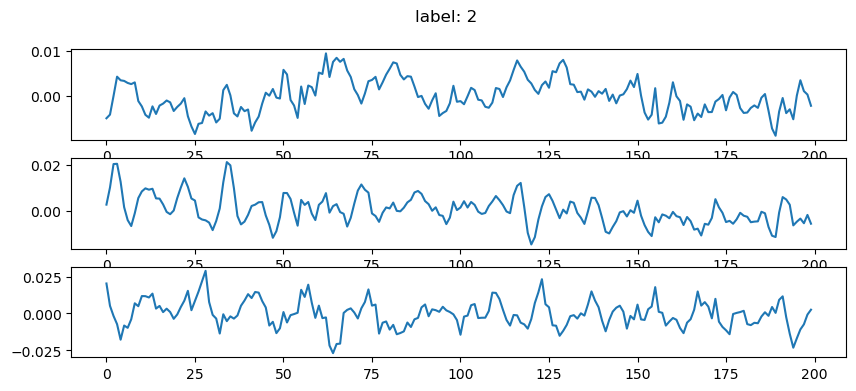

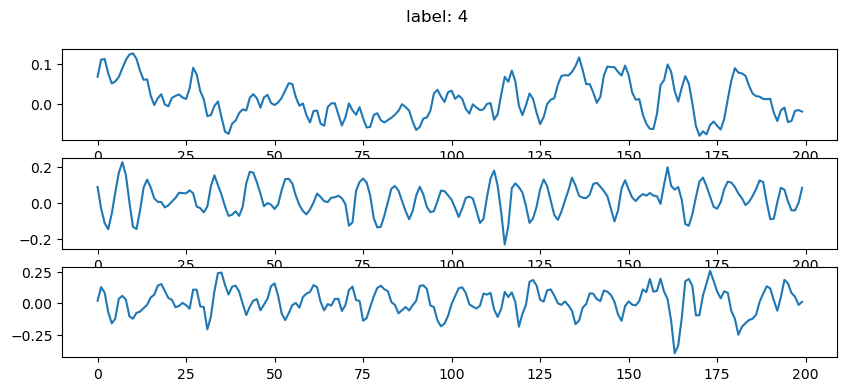

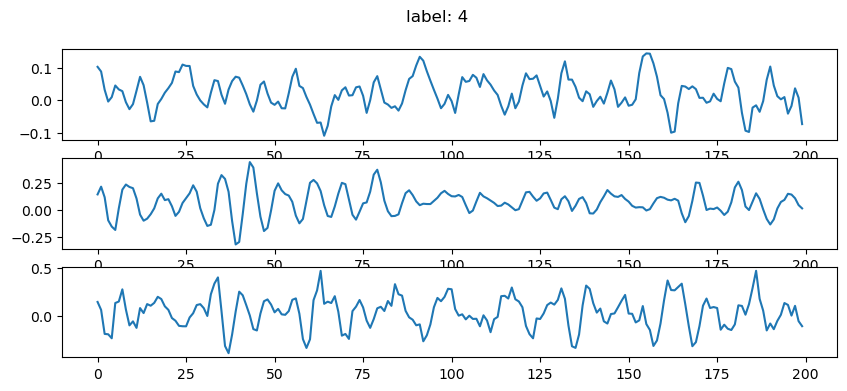

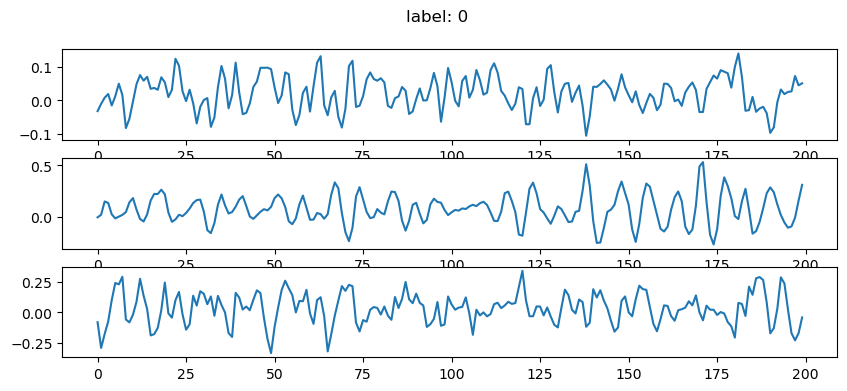

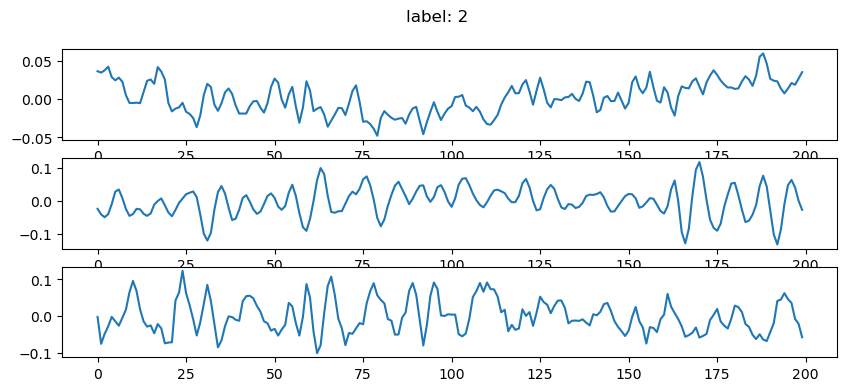

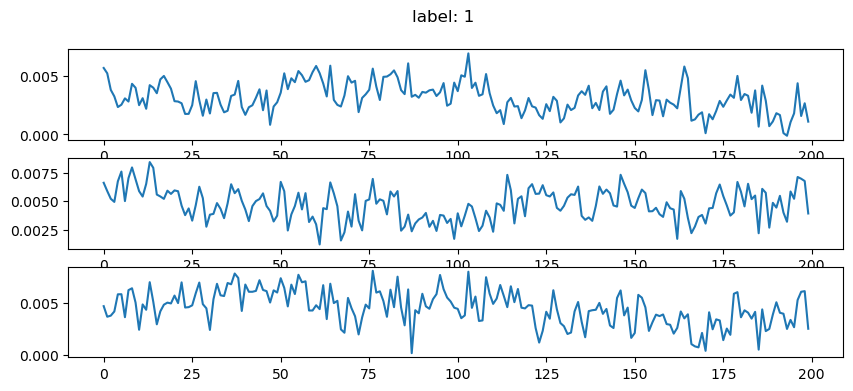

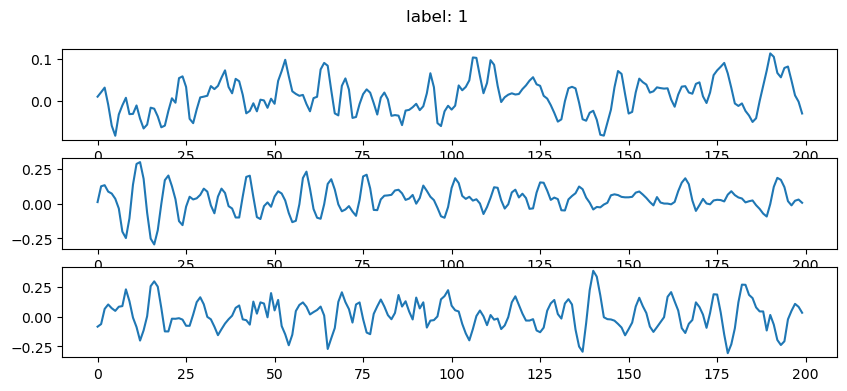

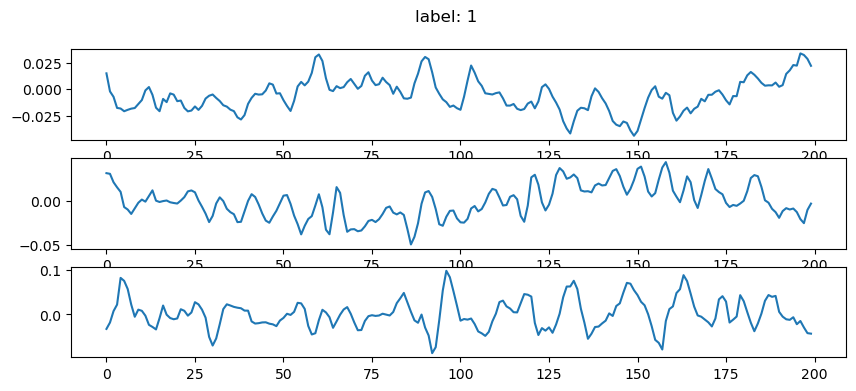

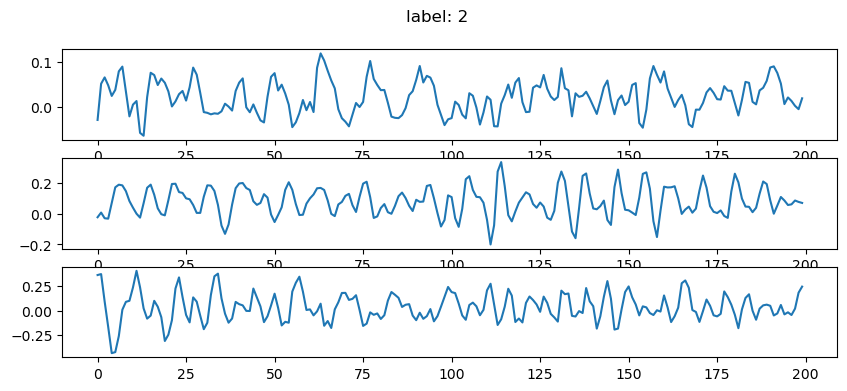

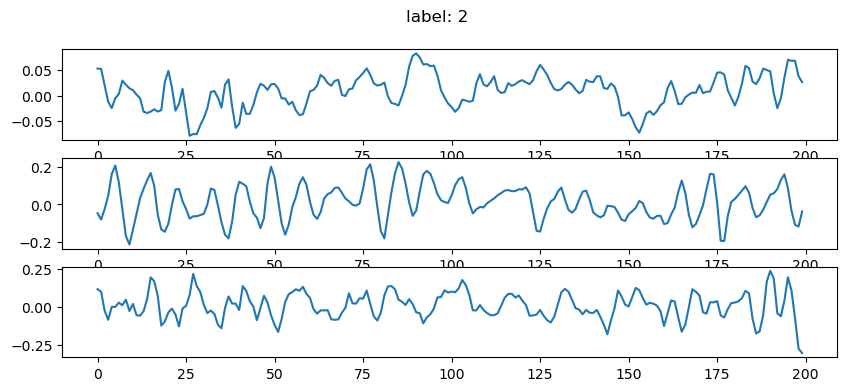

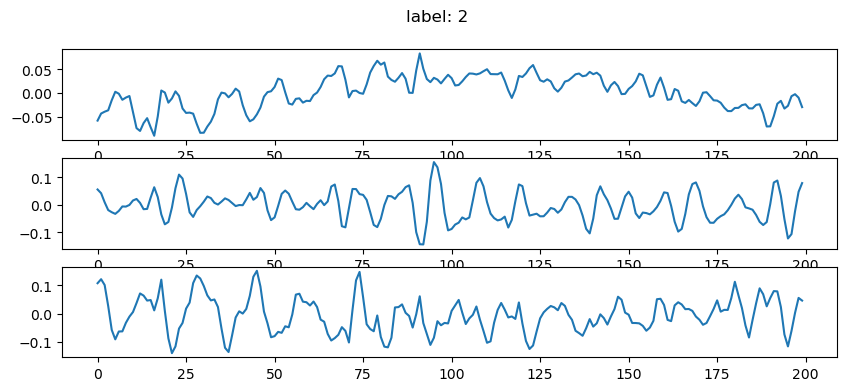

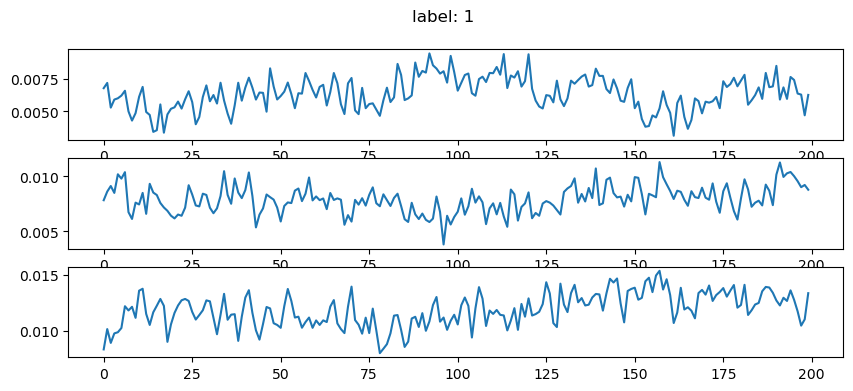

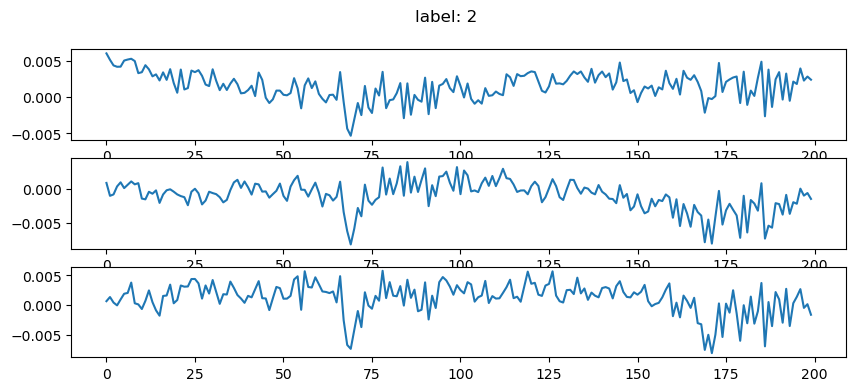

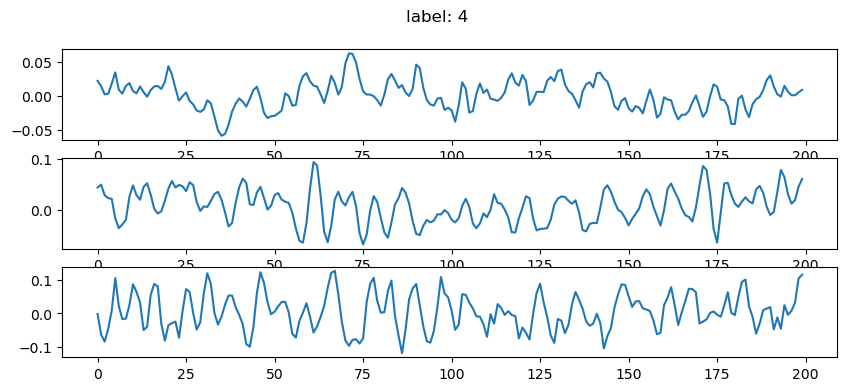

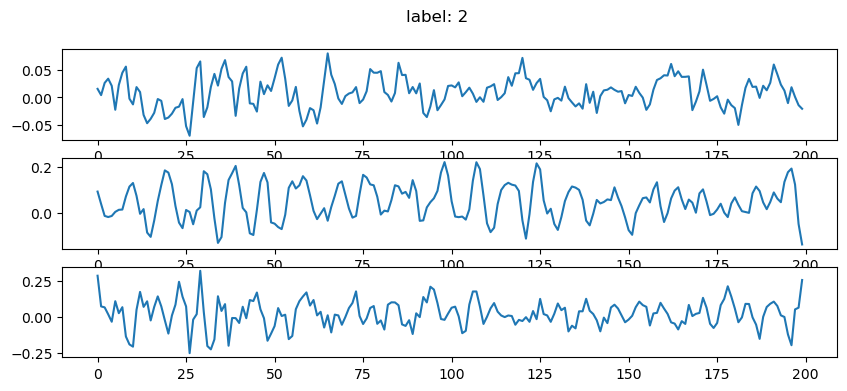

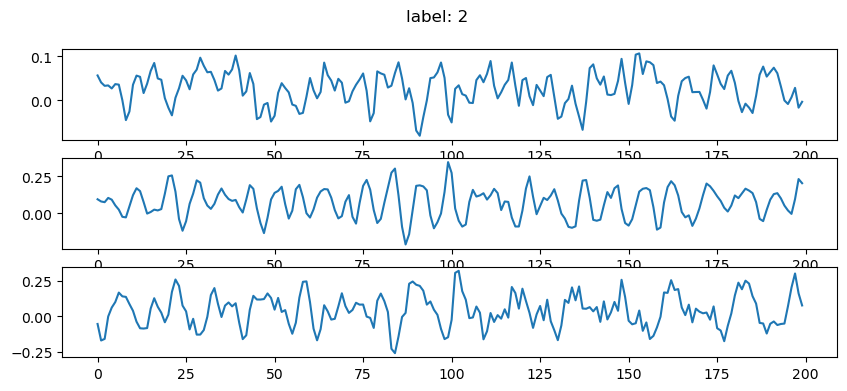

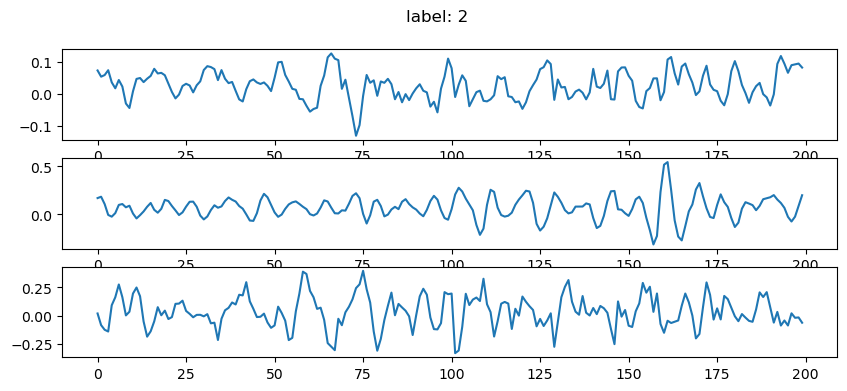

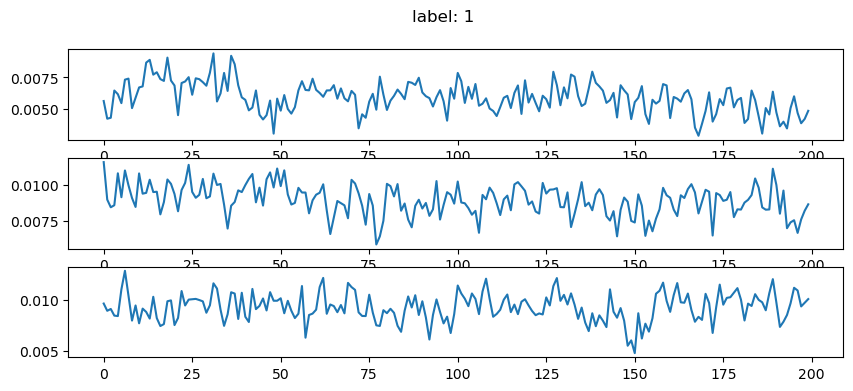

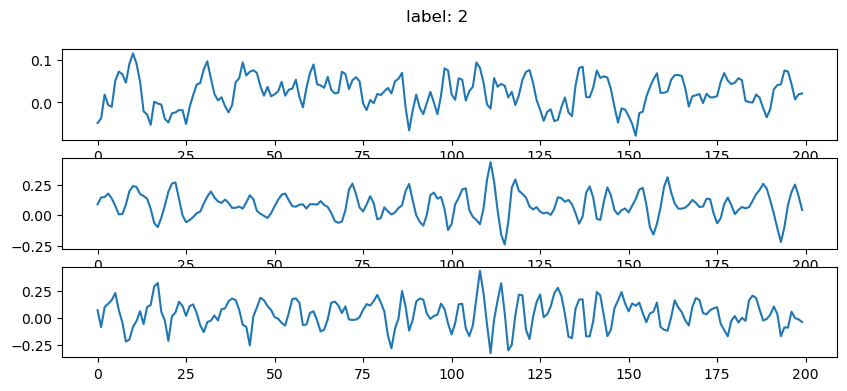

In [59]:
for i in range(len(fail_list)):
    plotting(fail_list[i][0],"label: "+str(fail_label[i]))
    